# Description and Software Disclaimer

Title: NIST SRD-205 IAST Calculator

Software Description: This notebook utilizes single-component isotherms in the NIST/ARPA-E Database of Novel Adsorbent Materials (http://adsorption.nist.gov/srd205) to estimate multicomponent adsorption characteristics using Ideal Adsorbed Solution Theory.

Author: Daniel W. Siderius, PhD

------------VERSION HISTORY----------------

2017-07-31:   v 1.0 (initial release)

------------SOFTWARE DISCLAIMER AND REDISTRIBUTION CONDITIONS----------------

This software was developed at the National Institute of Standards and Technology by employees of the Federal Government in the course of their official duties. Pursuant to Title 17 Section 105 of the United States Code this software is not subject to copyright protection and is in the public domain. This software is an experimental system. NIST assumes no responsibility whatsoever for its use by other parties, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. We would appreciate acknowledgement if the software is used.

This software can be redistributed and/or modified freely provided that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.

------------DECLARATION OF CONFLICTING INTERESTS----------------

Certain commercially available items may be identified in this paper. This identification does not imply recommendation by NIST, nor does it imply that it is the best available for the purposes described.

## User Guide

### Preface
This notebook uses the pyIAST package to apply "Ideal Adsorbed Solution Theory" (IAST) equations to the calculation of multicomponent adsorption isotherms from single-component adsorption isotherms. End-users should consult the pyIAST documentation (https://github.com/CorySimon/pyIAST, http://pyiast.readthedocs.io/en/latest/) to understand its syntax and warning codes.

This notebook is not an explanation of IAST; most of the IAST operations are done by the pyIAST package and, hence, are hidden from the user. For a discussion of IAST, one may consult the following references:
1. "Thermodynamics of Mixed-Gas Adsorption," A. L. Myers and J. M. Prausnitz, AIChE J., vol. 11, pp. 121-127 (1964).
2. "Effects of Molecular Siting and Adsorbent Heterogeneity on the Ideality of Adsorption Equilibria," M. Murthi and R. Q. Snurr, Langmuir, vol. 20, pp. 2489-2497 (2004).
3. "An Ideal Absorbed Solution Theory (IAST) Study of Adsorption Equilibria of Binary Mixtures of Methane and Ethane on a Templated Carbon," J. Chen, L. S. Loo, and K. WAng, J. Chem. Eng. Data, vol. 56, pp 1209-121 (2011).

As of 2017-07-31, pyIAST requires Python 3.x. The end user is responsible for installing Python 3.x and then confirming that pyIAST is loaded properly. Also, since it is not possible to automatically select an isotherm model for fitting an experimental isotherm; the end user must ensure that the selected model or isotherm fit adequately represents the input isotherm data. The different isotherm models available in pyIAST may be accessed by running 

pyiast._MODELS

### Usage
This notebook is intended as an example of how to use IAST in conjunction with isotherms served by the NIST SRD-205 application programming interface (API); actual use may require extensive modification of the Python code that follows as certain assumptions have been built-in to the code, though those assumptions will be pointed out. Use of this notebook follows the general sequence that follows, with each element corresponding to a major heading of the notebook below:
1. Import Required Python Packages
   This step simply imports the supporting packages required by the notebook
   
2. Define Custom Classes
   This step defines a custom class that is used to abstract the isotherm data from the SRD-205 API.

3. User Selection of Pure-Component Isotherms
   In this step, the user must identify the single-component isotherms that will be used for IAST. 

4. Select Isotherm Constants
   In this step, the user selects whether the IAST calculation is with an adsorptive isopleth (constant composition of the adsorptive phase, while the its pressure changes) or an adsorptive isobar (constant pressure of the adsorption phase, while its composition changes). The adsorptive composition must be set either 1) once for isopleth operation or 2) multiply [essentially, for each isotherm point] for isobar operation. Similarly, the adsorptive pressure must be set either 1) multiply [essentially, for each isotherm point] for isopleth operation or 2) once for isobar operation. In this notebook, composition is assumed to be given in mole fractions.
   
5. Instantiate Isotherms and Conduct Basic Error Checks
   This step create the isotherm objects based on the class definition in Step 2, and then performs basic tests to ensure thermodynamic consistency needed for the IAST calculations.

6. Common pyIAST Operations
   This step creates the Pandas dataframe objects based on the single-component isotherms defined in Step 3 and imported in Step 5.
   
7. a) Isopleth Calculation
   <br> This step (if "isopleth" operation has been selected) performs IAST calculations for multicomponent adsorption, in which the adsorptive phase composition is held fixed. The pressure of the adsorptive phase necessarily changes.
   <br>b) Isobar Calculation
   <br>This step (if "isobar" operation has been selected) performs IAST calculations for multicomponent adsorption, in which the adsorptive phase pressure is held fixed. The adsorptive composition changes according to the compositions defined in Step 4

### Warnings
1. This notebook conducts some basic checks:
   <br>1) Compatible pressure units across the source single-component isotherms
   <br>2) Compatible adsorption units across the source single-component isotherms
   <br>3) Same adsorbent across the source single-component isotherms
   <br>4) Ensuring that the composition list matches the number of source isotherms
 
   These checks can, of course, be overridden. IAST may, then, yield nonsensical results.

2. Units of input isotherms can be modified to be compatible. An end user is responsible for writing the code to make those conversions.

3. In principle, IAST can operate on any set of single-component adsorption isotherms measured at the same temperature; it does not check whether the adsorbent material is consistent between those source isotherms. Therefore, a user could apply IAST to single-component isotherms from different materials.

# 1. Import Python Packages

In [1]:
#NOTE: This tool uses the pyIAST package, which requires Python 3.x.
#End User is responsible for installation of missing packages using an appropriate Python package manager

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast
import json
import requests
import itertools

#Uncomment the following lines to suppress warnings
#import warnings ; warnings.filterwarnings('ignore')

## 2. Define Custom Classes

In [2]:
#Defines an isotherm object class
#NOTE: This class definition must be rewritten after the 2017 isotherm standard (multicomponent-capable)
# has been implemented in the SRD-205 API
class SRD205_isotherm:
    def __init__(self,filename):
        host='adsorption.nist.gov'
        URL = 'http://'+host+'/srd205/api/isotherm/'+filename
        isotherm_JSON = json.loads(requests.get(URL).content)
        self.filename = filename
        self.pressureUnits = isotherm_JSON["pressureUnits"]
        self.adsorptionUnits = isotherm_JSON["adsorptionUnits"]
        self.p_label = "Pressure ("+self.pressureUnits+")"
        self.ads_label = "Loading ("+self.adsorptionUnits+")"
        self.p_list = [ point["pressure"] for point in isotherm_JSON["isotherm_data"] ]
        self.ads_list = [ point["adsorption"] for point in isotherm_JSON["isotherm_data"] ]
        self.adsorbate = { "Name": isotherm_JSON["adsorbateGas"], 
                          "InChIKey": isotherm_JSON["InChIKey"] }
        self.adsorbent = { "Name": isotherm_JSON["adsorbentMaterial"], 
                          "hashkey": isotherm_JSON["hashkey"] }

## 3. User Selection of Pure-Component Isotherms

In [3]:
#Instructions:
#1. Select pure-component isotherms from NIST SRD-205, by their SRD-205 filename, defined as string variables.
#2. Assemble the pure-component isotherm string variables into a list named "isotherm_files"
#3. Specify the Isotherm Fitting Models (available models listed via the "pyiast._MODELS" command) for the
#   pure-component isotherms in a list named "models"

#Select the Isotherm Files
isotherm1 = '10.1002chem.200902144.Isotherm4.json' #CH4 on ZIF-8 @ 303K http://dx.doi.org/10.1002/chem.200902144
isotherm2 = '10.1002chem.200902144.Isotherm5.json' #CO2 on ZIF-8 @ 303K http://dx.doi.org/10.1002/chem.200902144
isotherm3 = '10.1002chem.200902144.Isotherm6.json' #N2  on ZIF-8 @ 303K http://dx.doi.org/10.1002/chem.200902144

#Assemble the isotherm filenames into a list
isotherm_files = [ isotherm1, isotherm2, isotherm3 ]

#Specify the Isotherm Fitting Models (Langmuir,)
model1 = "Langmuir"
model2 = "Langmuir"
model3 = "Langmuir"
models = [model1, model2, model3]

## 4. Select Isotherm Constants

In [4]:
#Instructions: Specify the multicomponent isotherm type, either "Isopleth" or "Isobar",
#  in the string variable "isotherm_type"
#  A. Isopleth (Fixed composition multicomponent isotherm, with varying total pressure)
#     1. User must specify the species mole fractions, in a list named "composition"
#  B. Isobar (Fixed pressure multicomponent isotherm, with varying composition)
#     1. User must specify the total pressure in the variable "Pressure" (float)
#     2. User must specify the species mole fractions, in an array of size (points)x(number of species)
#     3. User must specify the xaxis for isotherm and selectivity plots, in a list of length (points+1)
#  C. User must comment out (with #) the block of code for the unused isotherm type


#-----------ISOPLETH TYPE ISOTHERM---------------------------
#Isopleth Isotherm type (constant adsorptive composition)
#isotherm_type = "Isopleth"
#composition = [0.05, 0.45, 0.50] #Mole Fractions
#------------------------------------------------------------

#-----------ISOBAR TYPE ISOTHERM-----------------------------
#Isobar Isotherm type (constant total adsorptive pressure)
isotherm_type = "Isobar"
Pressure = 10.0 #Same units as input isotherms (default: bar)
points = 10; composition = []
for i in range(points):
    composition.append( [0.05, 0.01+(0.94-0.01)*float(i)/float(points-1), 0.94+(0.01-0.94)*float(i)/float(points-1)])
xaxis = [composition[k][1] for k in range(points)] #Choose the x-axis, appropriate the composition variation
#------------------------------------------------------------

## 5. Instantiate Isotherms and Conduct Basic Error Checks

In [5]:
#Instructions: This block of code should not be altered unless a user is
# overriding an error check

#Instantiate the pure-component isotherms
isotherms = [ SRD205_isotherm(file) for file in isotherm_files ]
num_species = len(isotherms)
spec_pairs = list(itertools.combinations(range(num_species), 2))

#Basic System Checks:
print( 'ESSENTIAL SYSTEM CHECKS: ')

# Confirm that pressure units are consistent
pressure_units = [ isotherm.pressureUnits for isotherm in isotherms ]
if len(set(pressure_units)) > 1:
    print('ERROR: Incompatible pressure units in isotherms')
    for (i,isotherm) in enumerate(isotherms):
        print( '  Isotherm '+str(i+1)+": "+isotherm.pressureUnits )
    raise ValueError("Incompatible pressure units in isotherms")
else:
    print('Pressure units are compatible: '+list(set(pressure_units))[0] )
    
# Confirm that adsorption units are consistent
adsorption_units = [ isotherm.adsorptionUnits for isotherm in isotherms ]
if len(set(adsorption_units)) > 1:
    print('ERROR: Incompatible adsorption units in isotherms')
    for (i,isotherm) in enumerate(isotherms):
        print( '  Isotherm '+str(i+1)+": "+isotherm.adsorptionUnits )
    raise ValueError("Incompatible adsorption units in isotherms")
else:
    print('Adsorption units are compatible: '+list(set(adsorption_units))[0] )

# Confirm that the material is the same across the isotherms
material_hashes = [ isotherm.adsorbent["hashkey"] for isotherm in isotherms ]
material_names = [ isotherm.adsorbent["Name"] for isotherm in isotherms ]
if len(set(material_hashes)) > 1:
    
    print( 'WARNING: Different Materials Specified' )
    for (i,isotherm) in enumerate(isotherms):
        print( '  Isotherm '+str(i+1)+": "+isotherm.adsorbent["Name"] )
else:
    print( 'Same material is specified: '+list(set(material_names))[0] )
    
# List the adsorbates
print()
print( 'Adsorbate Species' )
for (i,isotherm) in enumerate(isotherms):
    print(' Species '+str(i+1)+" : "+isotherm.adsorbate["Name"])

# Check the composition list size
print()
if isotherm_type == "Isopleth":
    if len(composition) != num_species:
        print("ERROR: Mole Fraction list has incorrect size")
        print("Number of Species: "+str(num_species))
        print("Composition List: "+str(composition))
    else:
        print("Composition list size matches number of species")
elif isotherm_type == "Isobar":
    check = True
    for (i,c) in enumerate(composition):
        if len(c) != num_species:
            print("ERROR: Mole Fraction list has incorrect size at line "+str(i))
            print("Number of Species: "+str(num_species))
            print("Composition List: "+str(c))
            check = False
            break
    if check:
        print("Composition list size matches number of species")
else:
    print("ERROR: Unknown isotherm type: "+isotherm_type)
    
    
# Check the composition vectors for completeness
print()
tolerance = 0.001 #Tolerance for sums over composition
if isotherm_type == "Isopleth":
    if np.abs(1.0-sum(composition)) > tolerance:
        print("ERROR: Composition list does not add to 1.0 (within tolerance "+str(tolerance)+")")
    else:
        print("Composition list meets numerical tolerance "+str(tolerance))
elif isotherm_type == "Isobar":
    check = True
    for (i,c) in enumerate(composition):
        if np.abs(1.0-sum(c)) > tolerance:
            print("ERROR: Composition list does not add to 1.0 (within tolerance "+str(tolerance)+")")
            print(" at line "+str(i))
            print("Composition List: "+str(c))
            check = False
            break
    if check:
        print("Composition list meets numerical tolerance "+str(tolerance))
else:
    print("ERROR: Unknown isotherm type: "+isotherm_type)

ESSENTIAL SYSTEM CHECKS: 
Pressure units are compatible: bar
Adsorption units are compatible: mmol/g
Same material is specified: ZIF-8

Adsorbate Species
 Species 1 : Methane
 Species 2 : Carbon Dioxide
 Species 3 : Nitrogen

Composition list size matches number of species

Composition list meets numerical tolerance 0.001


## 6. Common pyIAST Operations

10.1002chem.200902144.Isotherm4.json
Methane adsorption on ZIF-8


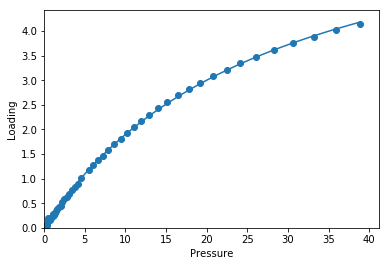

10.1002chem.200902144.Isotherm5.json
Carbon Dioxide adsorption on ZIF-8


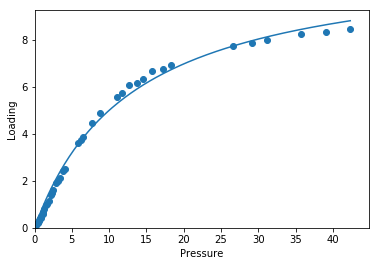

10.1002chem.200902144.Isotherm6.json
Nitrogen adsorption on ZIF-8


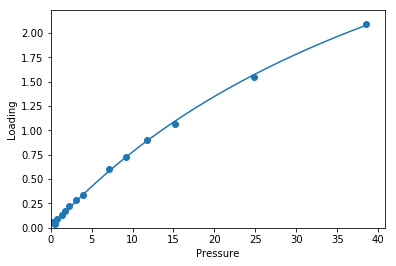

In [6]:
#Instructions: User must choose an isotherm model or select an interpolation option

#List Models:
#pyiast._MODELS

#Compose dataframes from the single-component isotherm data; generate models in pyIAST and plot the data/fits
Spec_Isotherms = []
for isotherm,model in zip(isotherms,models):
    #Option 1: Fit the single-component isotherms to the model(s) specified previously.
    Spec_Isotherms.append(
        pyiast.ModelIsotherm(
            pd.DataFrame({ isotherm.p_label: isotherm.p_list, isotherm.ads_label: isotherm.ads_list }),
            loading_key=isotherm.ads_label,
            pressure_key=isotherm.p_label,
            model=model)
        )
    #Option 2: Interpolate the single-component isotherm
    #Spec_Isotherms.append(
    #    pyiast.InterpolatorIsotherm(
    #        pd.DataFrame({ isotherm.p_label: isotherm.p_list, isotherm.ads_label: isotherm.ads_list }),
    #        loading_key=isotherm.ads_label,
    #        pressure_key=isotherm.p_label)
    #    )
    print(isotherm.filename)
    print(isotherm.adsorbate["Name"]+' adsorption on '+isotherm.adsorbent["Name"])
    pyiast.plot_isotherm(Spec_Isotherms[-1],withfit=True,
                         xlogscale=False)

## 7a. Isopleth Calculation

In [7]:
#Instructions: This code block will execute if isotherm_type="Isopleth"

#Option 1: Isopleth [Constant composition, varying pressure isotherm]
if isotherm_type == 'Isopleth':
    pmin = min(sum([isotherm.p_list for isotherm in isotherms],[]))
    pmax = max(sum([isotherm.p_list for isotherm in isotherms],[]))
    pressure = np.linspace(pmin,pmax,10)
    spec_pairs = list(itertools.combinations(range(num_species), 2))

    IAST_isotherm = []
    selectivity_isotherm = []
    for p in pressure:
        partial_p = [ c*p for c in composition] #Assume ideality for computing partial pressures
        Spec_loadings = pyiast.iast(partial_p,Spec_Isotherms,verboseflag=False,warningoff=True)
        IAST_isotherm.append(list(Spec_loadings))

        y = [ loading/sum(Spec_loadings) for loading in Spec_loadings ]
        selectivity = [ [ (y[i]/composition[i])/(y[j]/composition[j]) 
                         for j in range(num_species) ] for i in range(num_species) ]
        selectivity_isotherm.append( selectivity )
        #print(p, Spec_loadings[0], Spec_loadings[1], Spec_loadings[2], selectivity[0][1], selectivity[0][2], selectivity[1][2])

    fig = plt.figure()
    for (j,isotherm) in enumerate(isotherms):
        plt.plot(pressure,[ spec[j] for spec in IAST_isotherm ],'.-',label=isotherm.adsorbate["Name"])
    plt.xlabel(isotherms[0].p_label)
    plt.ylabel(isotherms[0].ads_label)
    plt.legend()
    plt.show()

    fig = plt.figure
    for i,j in spec_pairs:
        plt.plot(pressure, [s[i][j] for s in selectivity_isotherm], '.-', 
                 label=isotherms[i].adsorbate["Name"]+'-'+isotherms[j].adsorbate["Name"] )
    plt.xlabel(isotherms[0].p_label)
    plt.ylabel(r'Selectivity ($i/j$)')
    plt.legend()
    plt.show()

## 7b. Isobar Calculation

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/isotherms.py:308: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


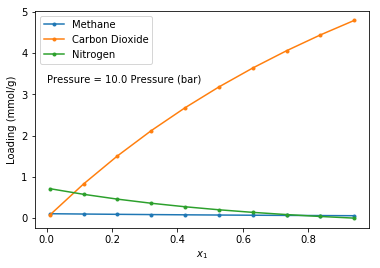

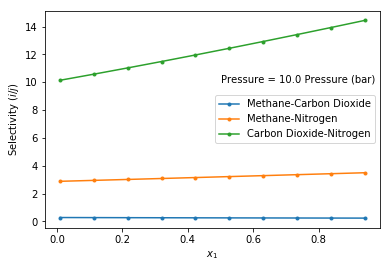

In [8]:
#Instructions: This code block will execute if isotherm_type="Isobar"

#Option 2: Isobar [Constant pressure, varying composition isotherm]
if isotherm_type == 'Isobar':
    IAST_isotherm = []
    selectivity_isotherm = []
    for c in composition:
        partial_p = [ Pressure*ci for ci in c ] #Assume ideality for computing partial pressures
        Spec_loadings = pyiast.iast(partial_p,Spec_Isotherms,verboseflag=False,warningoff=True)
        IAST_isotherm.append(list(Spec_loadings))

        y = [ loading/sum(Spec_loadings) for loading in Spec_loadings ]
        selectivity = [ [ (y[i]/c[i])/(y[j]/c[j]) 
                         for j in range(num_species) ] for i in range(num_species) ]
        selectivity_isotherm.append(selectivity)
        #print( c[0], c[1], c[2], Spec_loadings[0], Spec_loadings[1], Spec_loadings[2])
        #print( c[0], c[1], c[2], y[0], y[1], y[2])
        #print( c[0], c[1], c[2], selectivity[0][1], selectivity[0][2], selectivity[1][2])
    
    fig = plt.figure()
    for (i,isotherm) in enumerate(isotherms):
        plt.plot(xaxis,
                 [spec[i] for spec in IAST_isotherm],
                 '.-',label=isotherm.adsorbate["Name"])
    plt.xlabel(r'$x_1$')
    plt.ylabel(isotherms[0].ads_label)
    plt.text(0.0, 3.3, r'Pressure = '+str(Pressure)+' '+isotherms[0].p_label)
    plt.legend()
    plt.show()

    fig = plt.figure
    for i,j in spec_pairs:
        plt.plot(xaxis,[s[i][j] for s in selectivity_isotherm], '.-', 
                 label=isotherms[i].adsorbate["Name"]+'-'+isotherms[j].adsorbate["Name"] )
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'Selectivity ($i/j$)')
    plt.text(0.5, 10.0, r'Pressure = '+str(Pressure)+' '+isotherms[0].p_label)
    plt.legend()
    plt.show()